In [1]:
import sys ###policyevaluatior2header
sys.path.append('../scripts/')
from puddle_world import *
import itertools
import collections

In [2]:
class PolicyEvaluator: #方策を評価して，状態価値関数を求める
    def __init__(self, widths, goal, puddles, time_interval, sampling_num, \
                 puddle_coef=100.0, lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T):
        self.pose_min = np.r_[lowerleft, 0] #ロボットが動く範囲
        self.pose_max = np.r_[upperright, math.pi*2] #thetaの範囲0〜2πで固定
        self.widths = widths #区間の幅
        self.goal = goal #ゴールの記録
        
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int) #各軸の区間数を計算
        nx, ny, nt = self.index_nums #区間数を保存
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt))) #全部のインデックスの組み合わせを作成
        
        self.value_function, self.final_state_flags =  self.init_value_function() #状態価値関数などの初期化
        self.policy = self.init_policy()
        self.actions = list(set([tuple(self.policy[i]) for i in self.indexes])) #重複を削除し，3種類の行動が入ったリストを作成
        
        self.state_transition_probs = self.init_state_transition_probs(time_interval, sampling_num) #状態遷移確立のデータをセット
        self.depths = self.depth_means(puddles, sampling_num)

        self.time_interval = time_interval
        self.puddle_coef = puddle_coef
        
    def policy_evaluation_sweep(self): #終端状態以外の状態に対してaction_valueを実行
        max_delta = 0.0
        for index in self.indexes:
            if not self.final_state_flags[index]:
                q = self.action_value(tuple(self.policy[index]), index) #actionはタプルに直してから与える
                
                delta = abs(self.value_function[index] - q) #価値の変化量を記録
                max_delta = delta if delta > max_delta else max_delta #価値の変化量を比較，最大のdeltaを保存
                
                self.value_function[index] = q
            
        return max_delta #最大のdeltaを返す
                
    def action_value(self, action, index): #式(10.17)の実装
        value = 0.0
        for delta, prob in self.state_transition_probs[(action, index[2])]:  #遷移先のインデックスの差分と確率を抽出
            after = tuple(self.out_correction(np.array(index).T + delta) ) #差分を遷移先のインデックスに直す
            reward = - self.time_interval * self.depths[(after[0], after[1])] * self.puddle_coef - self.time_interval #報酬を計算
            value += (self.value_function[after] + reward) * prob #右辺のシグマ内を計算

        return value
            
    def out_correction(self, index): #インデックスが状態遷移によって範囲をはみ出たときの処理をする
        index[2] = (index[2] + self.index_nums[2])%self.index_nums[2] #向きθを正規化してインデックスを返す
                
        return index
        
    def depth_means(self, puddles, sampling_num): #XY平面上の各区画について深さをリスト化する
        ###セルの中の座標を均等にサンプリング###
        dx = np.linspace(0, self.widths[0], sampling_num) 
        dy = np.linspace(0, self.widths[1], sampling_num)
        samples = list(itertools.product(dx, dy))
        
        tmp = np.zeros(self.index_nums[0:2]) #深さの合計が計算されて入る
        for xy in itertools.product(range(self.index_nums[0]), range(self.index_nums[1])): #各位置での水たまりの深さを足す
            for s in samples:
                pose = self.pose_min + self.widths*np.array([xy[0], xy[1], 0]).T + np.array([s[0], s[1], 0]).T #セルの中心の座標
                for p in puddles:
                    tmp[xy] += p.depth*p.inside(pose) #深さに水たまりの中か否か（1 or 0）をかけて足す
                        
            tmp[xy] /= sampling_num**2 #深さの合計から平均値に変換
                       
        return tmp #深さの平均値が入った2次元リストを返す
        
    def init_state_transition_probs(self, time_interval, sampling_num): #状態遷移確立のデータをセットするための関数
        #セルの中の座標を均等にsampling_num**3点サンプリング# #1つのセルの中から均等に姿勢をサンプリングしてリスト化
        dx = np.linspace(0.001, self.widths[0]*0.999, sampling_num) #隣のセルにはみ出さないように端を避ける
        dy = np.linspace(0.001, self.widths[1]*0.999, sampling_num)
        dt = np.linspace(0.001, self.widths[2]*0.999, sampling_num)
        samples = list(itertools.product(dx, dy, dt)) #各軸のリストを組み合わせて姿勢のリストを作成
        
        ###各行動、各方角でサンプリングした点を移動してインデックスの増分を記録###
        tmp = {}
        for a in self.actions:
            for i_t in range(self.index_nums[2]):
                transitions = []
                for s in samples: #samples内の姿勢がどこに状態遷移するか統計を取る処理
                    before = np.array([s[0], s[1], s[2] + i_t*self.widths[2]]).T + self.pose_min #遷移前の姿勢を作成
                    before_index = np.array([0, 0, i_t]).T #遷移前のインデックス
                
                    after = IdealRobot.state_transition(a[0], a[1], time_interval, before) #遷移後の姿勢に変換，ノイズ無し
                    after_index = np.floor((after - self.pose_min)/self.widths).astype(int) #遷移後のインデックス
                    
                    transitions.append(after_index - before_index) #インデックスの変化量を保存
                    
                unique, count = np.unique(transitions, axis=0, return_counts=True) #インデックスの変化量の頻度が集計
                probs = [c/sampling_num**3 for c in count] #頻度をサンプル数で割って確率に変換
                tmp[a,i_t] = list(zip(unique, probs)) #どれだけの確率でどれだけインデックスが変化するかが保存
                
        return tmp

    def init_policy(self):  #各行動に対応する制御指令値を格納する3次元配列を準備し，各離散状態の中心座標を求め，
                            #中心座標に対して制御指令値を配列に収める
        tmp = np.zeros(np.r_[self.index_nums,2]) #制御出力が2次元なので、配列の次元を4次元に
        for index in self.indexes:
            center = self.pose_min + self.widths*(np.array(index).T + 0.5)  #セルの中心の座標
            tmp[index] = PuddleIgnoreAgent.policy(center, self.goal)
            
        return tmp
    
    def init_value_function(self): #初期化を行う関数
        v = np.empty(self.index_nums) #全離散状態を要素に持つ配列を作成
        f = np.zeros(self.index_nums) #同上
        
        for index in self.indexes: #各離散状態が終端状態かどうかを判定，終端状態ならゴールの価値を代入
            f[index] = self.final_state(np.array(index).T)
            v[index] = self.goal.value if f[index] else -100.0
                
        return v, f
        
    def final_state(self, index): #各離散状態が終端状態かどうかを判定する関数
        x_min, y_min, _ = self.pose_min + self.widths*index #xy平面で左下の座標
        x_max, y_max, _ = self.pose_min + self.widths*(index + 1) #右上の座標
        
        corners = [[x_min, y_min, _], [x_min, y_max, _], [x_max, y_min, _], [x_max, y_max, _] ] #4隅の座標
        return all([self.goal.inside(np.array(c).T) for c in corners ]) #全部のgoal.insideがTrueであること

In [3]:
import seaborn as sns   ###policyevaluator6create

puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)] 
pe = PolicyEvaluator(np.array([0.2, 0.2, math.pi/18]).T, Goal(-3,-3), puddles, 0.1, 10)

counter = 0 #スイープの回数

1 54.076220000000006
2 53.85750528
3 47.920786948
4 43.165992809471994
5 38.82614599589999
6 34.92590254127054
7 31.559431117143326
8 31.530735627105408
9 30.87633426963437
10 29.785013383303713
11 28.35875085384682
12 26.801810668174326
13 25.88783280697892
14 25.739418781996278
15 25.28198645857328
16 24.578882106661993
17 19.25455310190584
18 17.938698749483393
19 15.776343433340237
20 14.552531262717785
21 13.976243292596749
22 12.865531691213668
23 12.570221372178302
24 11.95071796184613
25 11.259669991523673
26 10.397895995530554
27 9.747425125210732
28 9.451902632534932
29 8.899812415397015
30 8.624448141379325
31 8.340356860166168
32 7.9402594282643335
33 7.6050303727135855
34 7.293399462125443
35 7.033004226681797
36 6.813408506959291
37 6.699075002108387
38 6.5678924515890245
39 6.3802702431715375
40 6.2061096935009274
41 6.044071337759647
42 5.897506602725187
43 5.763942941784833
44 5.6378461325625935
45 5.51871528533561
46 5.406096862065283
47 5.299575974453745
48 5.1987690

<IPython.core.display.Javascript object>


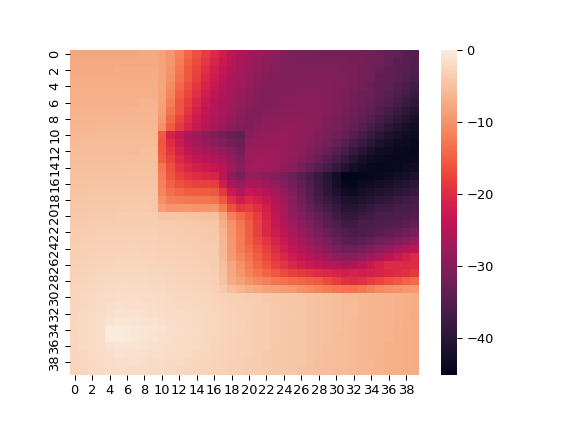

In [4]:
delta = 1e100

while delta > 0.01:
    delta = pe.policy_evaluation_sweep()
    counter += 1
    print(counter, delta)

v = pe.value_function[:, :, 18]
sns.heatmap(np.rot90(v), square=False)
plt.show()